# CLEAN BUILD FROM SCRATCH MIT-B2 on patches 768x768

# imports

In [1]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torch.cuda.amp as amp
is_amp = True

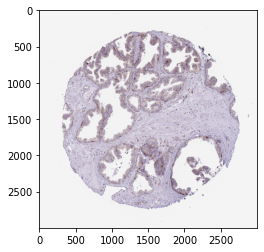

In [2]:
img1 = cv.imread('./../data/train_images/10044.tiff')[:, :, ::-1]
plt.imshow(img1)
plt.show()

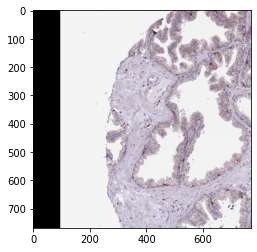

In [3]:
img2 = cv.imread('./../data/train_images_patches_768_overlap/10044_00010.png')[:, :, ::-1]
plt.imshow(img2)
plt.show()

# data

In [4]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

# model testing

In [5]:
from model import Net
from mit import *

## data 768

In [6]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_images_patches_768_overlap/'
TRAIN_MASKS_DIR = './../data/train_masks_patches_768_overlap/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

SPATIAL_SIZE = 768 # размер патча


In [7]:
train_df = pd.read_csv(TRAIN_CSV)

In [8]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [9]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [10]:
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,4.0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0.0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0.0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0.0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,4.0


In [11]:
def make_768_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('train_images_', 'train_masks_')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [12]:
train_df_768 = make_768_dataset(train_df)
print(train_df_768.shape)
train_df_768.head()

(8658, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
1,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
2,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
3,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
4,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4


In [13]:
train_df_768.iloc[0]['image']

'./../data/train_images_patches_768_overlap/10044_00013.png'

In [14]:
train_df_768.iloc[0]['mask']

'./../data/train_masks_patches_768_overlap/10044_00013.png'

In [15]:
train_df_768.iloc[0]['id']

10044

In [16]:
# ---------------------------------------------------------------
# WARNING! THIS RESCALE IS INJECTED IN SWIN TRANSFORMER ALREADY!
#   RGB LAYER
# IT'S INPUTS HAVE TO BE IMAGE IN 0..1!
# ---------------------------------------------------------------

In [17]:
train_transform= A.Compose([
#     A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(p=0.25),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(-0.1, 0.5),rotate_limit=90, p=0.5),
    A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.25),
    A.Blur(blur_limit=5, p=0.1),
    A.GaussNoise(var_limit=(20, 100), p=0.2),
    A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [18]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [19]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

# model

In [20]:
!nvidia-smi

Tue Aug 23 08:40:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   50C    P0    42W / 300W |     57MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   58C    P0   216W / 300W |  28962MiB / 32478MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [21]:
device = 'cuda:0'
DEVICE = device

In [22]:
pretrain_dir = './../mit-b2-segformer-first-try/'

In [23]:
model = Net().to(device)

In [24]:
chkpts = []
for i, fname in enumerate(sorted(glob('./checkpoint_fold_3/mit-b2_ep_*_dice_*.pt'))):
#     print(fname)
    bname = os.path.basename(fname)
    spt = bname.split('_')
    epoch = int(spt[2])
    dice = float(spt[4].rsplit('.', maxsplit=1)[0])
    print(i, '   ', epoch, dice)
    chkpts.append((fname, dice, epoch))

0     0 0.418632
1     1 0.662263
2     2 0.711303
3     3 0.715399
4     4 0.727583
5     5 0.73786
6     6 0.73744
7     7 0.742628
8     8 0.739406
9     9 0.740899
10     10 0.750366
11     11 0.765636
12     12 0.758635
13     13 0.749827
14     14 0.745528
15     15 0.745884
16     16 0.760473
17     17 0.761479
18     18 0.752354
19     19 0.753772
20     20 0.762061
21     21 0.758873
22     22 0.767908
23     23 0.760641
24     24 0.750913
25     25 0.761548
26     26 0.770503
27     27 0.758771
28     28 0.762968
29     29 0.75468
30     30 0.754403
31     31 0.750627
32     32 0.769125
33     33 0.753309
34     34 0.755348
35     35 0.768926
36     36 0.774553
37     37 0.755367
38     38 0.764858
39     39 0.758949
40     40 0.771542
41     41 0.764381
42     42 0.767548
43     43 0.765249
44     44 0.761166
45     45 0.757164
46     46 0.754987
47     47 0.773548
48     48 0.732792
49     49 0.760979
50     50 0.770782
51     51 0.771341
52     52 0.757977
53     53 0.7673

In [25]:
# to_swa_ckpts = chkpts[7:18]

In [26]:
to_swa_ckpts = list(sorted(chkpts, key=lambda x: x[1]))[-7:]

In [27]:
to_swa_ckpts

[('./checkpoint_fold_3/mit-b2_ep_060_dice_0.773215.pt', 0.773215, 60),
 ('./checkpoint_fold_3/mit-b2_ep_047_dice_0.773548.pt', 0.773548, 47),
 ('./checkpoint_fold_3/mit-b2_ep_036_dice_0.774553.pt', 0.774553, 36),
 ('./checkpoint_fold_3/mit-b2_ep_064_dice_0.774615.pt', 0.774615, 64),
 ('./checkpoint_fold_3/mit-b2_ep_055_dice_0.775979.pt', 0.775979, 55),
 ('./checkpoint_fold_3/mit-b2_ep_062_dice_0.778438.pt', 0.778438, 62),
 ('./checkpoint_fold_3/mit-b2_ep_066_dice_0.779049.pt', 0.779049, 66)]

In [28]:
model.load_state_dict(torch.load(to_swa_ckpts[-1][0], map_location=device), strict=False)

<All keys matched successfully>

In [29]:
swa_model = AveragedModel(model)

In [30]:
for el in tqdm(to_swa_ckpts):
    model.load_state_dict(torch.load(el[0], map_location=device), strict=False)
    swa_model.update_parameters(model)

100%|██████████| 7/7 [00:01<00:00,  5.07it/s]


In [32]:
# model.load_state_dict(torch.load('./checkpoint_fold_3_SAM/mit-b2_ep_501_dice_0.772775.pt', map_location=device))

# don't forget to call this after training

In [31]:
CURRENT_FOLD = 3

In [32]:
# swa_model.load_state_dict(torch.load('..'))

In [33]:
swa_model = swa_model.to(device)

In [34]:
class HubmapDataset768(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        if index % 100 == 0:
            print(index)
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        
        image = self.transform(image=image)['image'].to(device)

        return {'image': image}

In [35]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [36]:
train_dataset = HubmapDataset768(train_df_768[train_df_768['fold'] != CURRENT_FOLD], val_transform)
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=8, 
                          shuffle=False,
                          worker_init_fn=worker_init_fn,
                          num_workers=0
                         )

In [37]:
torch.optim.swa_utils.update_bn(loader_train, swa_model)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900


In [38]:
torch.save(swa_model.state_dict(), os.path.join(
                    '.', #'./checkpoint_fold_{}'.format(CURRENT_FOLD), 
                    'fold3_mitb2_BEST7.pt'
                )) 